# Feature Information

### train.csv

the train set, containing the user ids and whether they have churned.

msno: user id

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

### transactions.csv
transactions of users up until 2/28/2017.

msno: user id

payment_method_id: payment method

payment_plan_days: length of membership plan in days

plan_list_price: in New Taiwan Dollar (NTD)

actual_amount_paid: in New Taiwan Dollar (NTD)

is_auto_renew

transaction_date: format %Y%m%d

membership_expire_date: format %Y%m%d

is_cancel: whether or not the user canceled the membership in this transaction.


### user_logs.csv
daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

msno: user id

date: format %Y%m%d

num_25: # of songs played less than 25% of the song length

num_50: # of songs played between 25% to 50% of the song length

num_75: # of songs played between 50% to 75% of of the song length

num_985: # of songs played between 75% to 98.5% of the song length

num_100: # of songs played over 98.5% of the song length

num_unq: # of unique songs played

total_secs: total seconds played
    
    
### members.csv
user information. Note that not every user in the dataset is available.

msno

city

bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.

gender

registered_via: registration method

registration_init_time: format %Y%m%d

expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn 
behavior.


### Impoting Libraries

In [1]:
import numpy as np  # Numerical computing
import pandas as pd # Data manipulation and analysis
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Advanced data visualization
import sklearn # Machine learning algorithms and tools
import tensorflow as tf # Deep learning framework
import keras # High-level neural networks API
import statsmodels.api as sm # Statistical modeling
import scipy.stats as stats # Scientific computing
import plotly.express as px # Interactive data visualization
import nltk # Natural language processing
import xgboost as xgb # Gradient boosting library
import lightgbm as lgb # Gradient boosting framework
import catboost as cb # Gradient boosting on decision trees
import imblearn # Library for handling imbalanced datasets
# import eli5 # Explanation of machine learning models
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, roc_curve, auc
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import shap # Interpretability and explainability of models
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, roc_curve, auc
from keras.callbacks import EarlyStopping

C:\Users\burzi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datasets (CSV Files)

### Join all the dataframes into one dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [2]:
import pandas as pd

def read_and_join_csv_files(file_paths, chunk_size=10000):
    """
    Read multiple CSV files efficiently using chunking with Pandas and join them into one DataFrame.
    
    Args:
    - file_paths (dict): Dictionary containing file paths for each CSV file.
    - chunk_size (int, optional): Number of rows to read at a time. Default is 10,000.
    
    Returns:
    - DataFrame: Joined DataFrame containing data from all CSV files.
    """
    # Initialize empty dictionary to store DataFrames for each CSV file
    dfs = {}
    
    # Iterate over each file path and read CSV files in chunks
    for key, file_path in file_paths.items():
        # Initialize empty list to store chunks for the current DataFrame
        chunks = []
        
        # Iterate over chunks for the current DataFrame
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Append the chunk to the list of chunks for the current DataFrame
            chunks.append(chunk)
        
        # Concatenate the chunks for the current DataFrame into a single DataFrame
        df = pd.concat(chunks)
        
        # Store the DataFrame in the dictionary with the corresponding key
        dfs[key] = df
    
    # Join DataFrames
    joined_df = dfs["train"].merge(dfs["members"], on='msno', how='left')
    joined_df = joined_df.merge(dfs["transactions"], on='msno', how='left')
    joined_df = joined_df.merge(dfs["logs"], on='msno', how='left')
    
    return joined_df

In [3]:
# Example usage:
file_paths = {
    "members": "data/members_v3.csv",
    "train": "data/train_v2.csv",
    "transactions": "data/transactions_v2.csv",
    "logs": "data/user_logs_v2.csv"
}

In [4]:
joined_data_frame = read_and_join_csv_files(file_paths)

In [5]:
def preprocessing(data):
    '''
    This function takes a pandas dataframe as input, performs preprocessing (like dropping rows with NaN values, etc.),
    and then returns a pandas dataframe.
    
    Args:
        data (pandas.DataFrame): The input DataFrame.
    
    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    '''
    print("Preprocessing...")
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Drop rows with NaN values in any column
    data = data.dropna(how='any')
    print("Dropped rows with NaN values.")

    # Replace 'male' with 1 and 'female' with 2 in 'gender'
    gender_mapping = {'male': 1, 'female': 2}
    data['gender'] = data['gender'].map(gender_mapping)

    # Convert float date to datetime for date columns
    date_columns = ['registration_init_time', 'transaction_date', 'membership_expire_date', 'date']
    for col in date_columns:
        data[col] = pd.to_datetime(data[col], format='%Y%m%d', errors='ignore')
    print("Converted float date columns to datetime.")
    
    # Drop the 'msno' column
    #data = data.drop(columns=['msno'])

    # Reorder columns to move 'is_churn' towards the end
    if 'is_churn' in data.columns:
        churn_column = data.pop('is_churn')
        data['is_churn'] = churn_column

    print("Complete!")
    return data


In [6]:
# Preprocess the undersampled DataFrame 'undersampled_df' using the 'preprocessing' function,
# and store the preprocessed DataFrame in 'preprocessed_df'.
preprocessed_df = preprocessing(joined_data_frame)

Preprocessing...
Dropped rows with NaN values.
Converted float date columns to datetime.
Complete!


# Exploratory Data Analysis

In [7]:
def count_plot(data, columns):
    """
    Plot count plots for specified columns using matplotlib in separate windows.
    
    Args:
    - data (pandas.DataFrame): The DataFrame containing the data.
    - columns (list): List of columns to plot.
    """
    print("Plotting count plots...")
    
    # Plot count plots for each column
    for col in columns:
        # Create a new figure for each plot with larger horizontal size
        plt.figure(figsize=(10, 5))
        
        # Create count plot
        sns.countplot(x=col, data=data, palette='Set2')
        plt.title(f'Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    # Show plots
    plt.show()
    print("Plots completed!")

Plotting count plots...


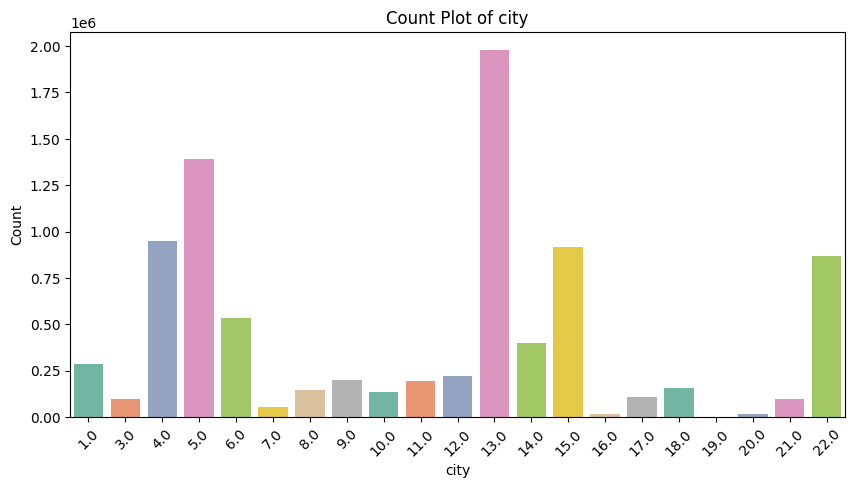

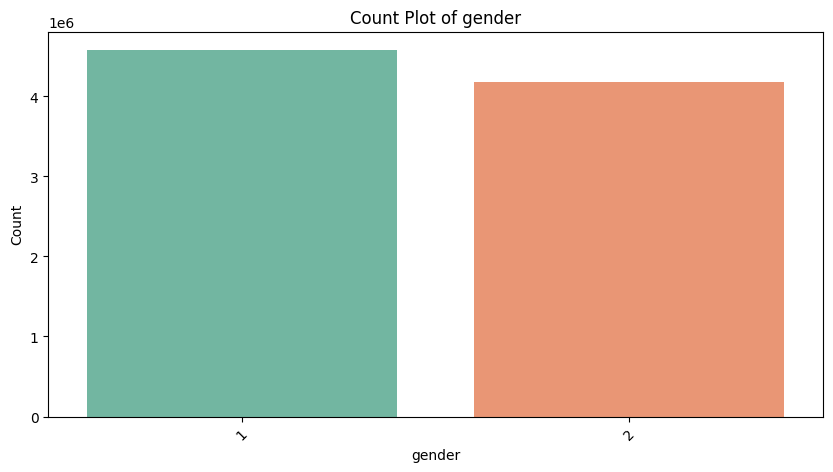

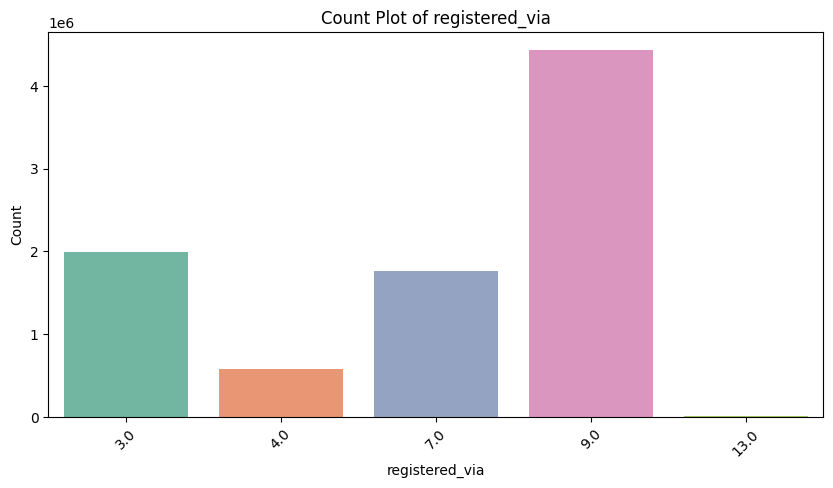

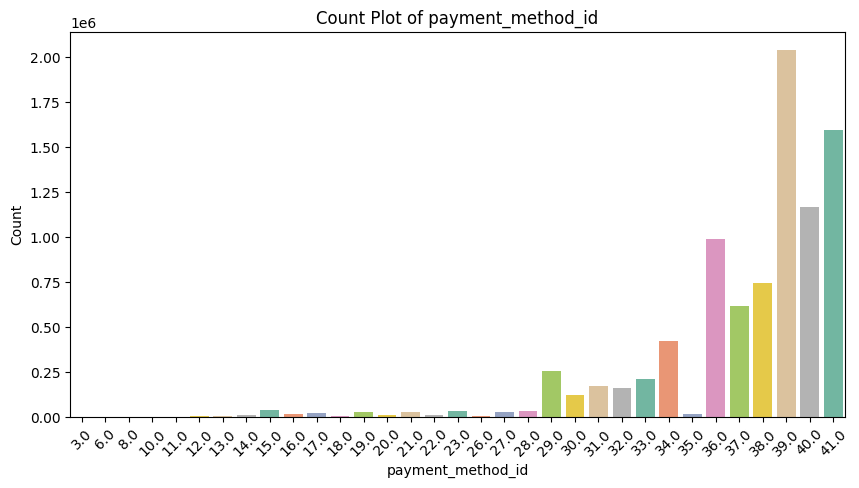

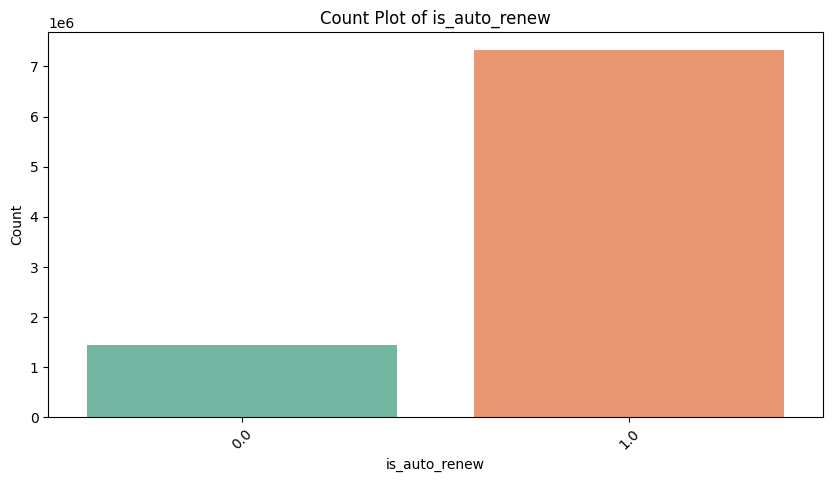

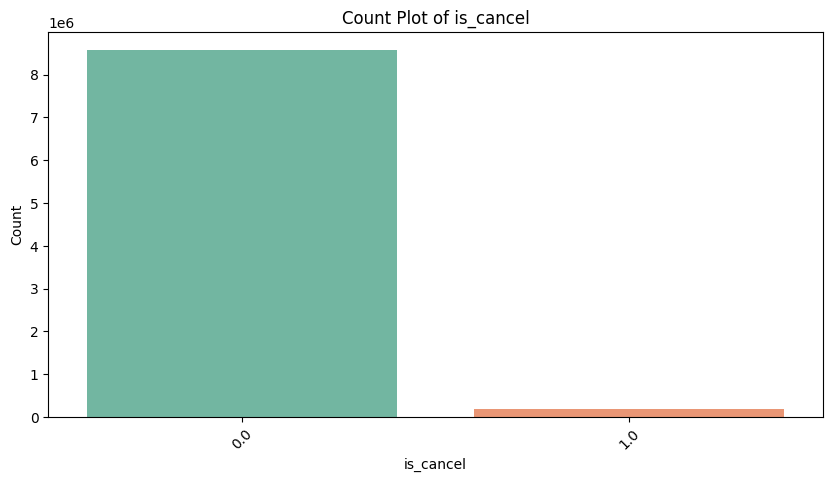

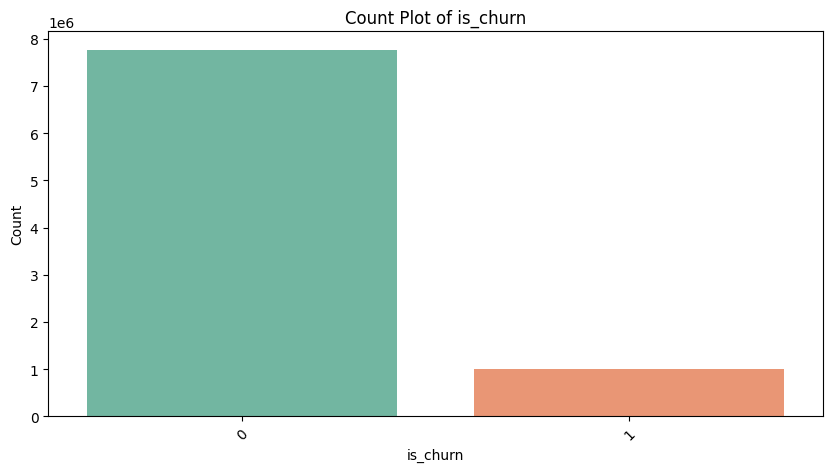

Plots completed!


In [8]:
# Example usage:
# Assuming 'df' is your DataFrame and 'columns' is a list of columns you want to plot
columns_to_plot = ['city', 'gender', 'registered_via', 'payment_method_id', 'is_auto_renew', 'is_cancel', 'is_churn']
count_plot(preprocessed_df, columns_to_plot)

In [9]:
def plot_is_churn(data):
    """
    Plot the distribution of the 'is_churn' column and check the ratio.

    Args:
    - data (pandas.DataFrame): The DataFrame containing the data.
    """
    # Count plot for 'is_churn'
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='is_churn', data=data, palette='Set2')
    plt.title('Distribution of is_churn')
    plt.xlabel('is_churn')
    plt.ylabel('Count')

    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.show()

    # Calculate churn ratio
    churn_ratio = data['is_churn'].value_counts(normalize=True) * 100
    print("Churn ratio:")
    print(churn_ratio)

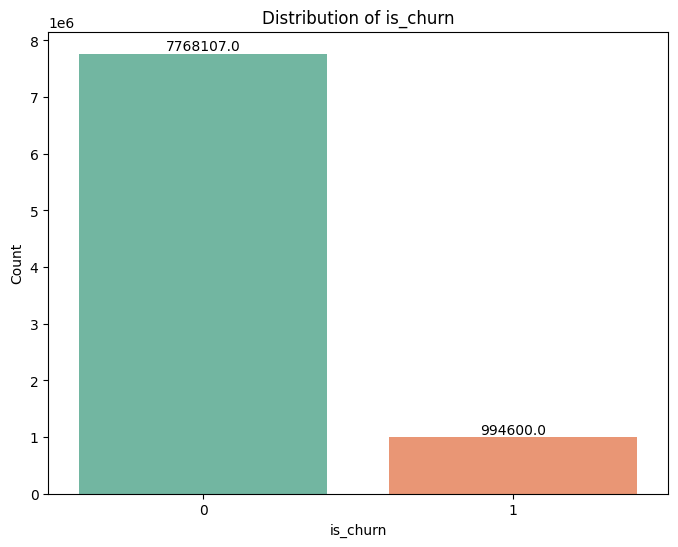

Churn ratio:
is_churn
0    88.649626
1    11.350374
Name: proportion, dtype: float64


In [10]:
# Example usage:
plot_is_churn(preprocessed_df)

The proportion of churned customers to those who haven't churned is imbalanced. To address this, we have the option to either undersample or oversample the data. Given that we have a sufficient number of data points for model training, undersampling the data seems like a viable approach.

# Undersampling the data

In [ ]:
def adjust_data_quantity(data: pd.DataFrame, churn_percent: float, data_size_percent: float = 100.0) -> pd.DataFrame:
    '''
    Adjust the quantity of not churned data points while keeping churned data points unchanged.

    Args:
        data (pandas.DataFrame): The input DataFrame.
        churn_percent (float): The percentage of churned data points in the output DataFrame.
        data_size_percent (float, optional): The percentage of data to be used for adjustment. Default is 100.0 (use all data).

    Returns:
        pandas.DataFrame: The adjusted DataFrame.
    '''
    print("Adjusting data quantity...")
    
    # Convert data_size_percent from percentage to fraction
    data_size = data_size_percent / 100.0
    
    # Apply data size adjustment
    data = data.sample(frac=data_size, random_state=0)
    
    # Calculate the number of churned and not churned data points
    churned_count = data['is_churn'].sum()
    not_churned_count = len(data) - churned_count
    
    # Calculate the desired number of not churned data points based on the percentage
    desired_not_churned_count = int(churned_count / (churn_percent / 100))
    
    # If the desired count is less than the current count, sample a subset of not churned data points
    if desired_not_churned_count < not_churned_count:
        # Sample a subset of not churned data points
        not_churned_data = data[data['is_churn'] == 0].sample(n=desired_not_churned_count, replace=False)
        churned_data = data[data['is_churn'] == 1]  # Keep churned data points unchanged
    else:
        # Repeat not churned data points to match the desired count
        repeat_factor = desired_not_churned_count // not_churned_count
        remainder = desired_not_churned_count % not_churned_count
        not_churned_data = pd.concat([data[data['is_churn'] == 0]] * repeat_factor)
        if remainder > 0:
            not_churned_data = pd.concat([not_churned_data, data[data['is_churn'] == 0].sample(n=remainder, replace=False)])
        churned_data = data[data['is_churn'] == 1]  # Keep churned data points unchanged
    
    # Concatenate churned and adjusted not churned data points
    adjusted_data = pd.concat([churned_data, not_churned_data])
    
    print("Data quantity adjustment complete!")
    
    # Calculate and print the ratio of churned to not churned data points
    ratio = churned_count / desired_not_churned_count
    print(f"Ratio of churned to not churned data points: {ratio:.2f}")
    
    # Print value counts after adjustment
    print("Value counts after adjustment:\n", adjusted_data['is_churn'].value_counts())
    
    # Plot count of each class
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    adjusted_data['is_churn'].value_counts().plot(kind='bar', color=['blue', 'orange'])
    plt.title('Count of Each Class')
    plt.xlabel('is_churn')
    plt.ylabel('Count')
    for i, value in enumerate(adjusted_data['is_churn'].value_counts()):
        plt.text(i, value, str(value), ha='center', va='bottom')
    
    # Plot ratio of class 1 to class 0
    plt.subplot(1, 2, 2)
    adjusted_data['is_churn'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
    plt.title('Ratio of Class 1 to Class 0')
    plt.xlabel('is_churn')
    plt.ylabel('Ratio')
    for i, value in enumerate(adjusted_data['is_churn'].value_counts(normalize=True)):
        plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    
    return adjusted_data

In [ ]:
undersampled_df = adjust_data_quantity(preprocessed_df, churn_percent = 50, data_size_percent = 100)

# Feature Engineering

In [ ]:
def feature_engineering(data):
    '''
    Perform feature engineering on the provided DataFrame.

    Args:
        data (pandas.DataFrame): The input DataFrame containing the original features.

    Returns:
        pandas.DataFrame: The DataFrame with additional engineered features.
    '''

    # Extract year, month, and day from registration_init_time
    data['registration_year'] = data['registration_init_time'].dt.year
    data['registration_month'] = data['registration_init_time'].dt.month
    data['registration_day'] = data['registration_init_time'].dt.day

    # Calculate subscription duration
    data['subscription_duration'] = (data['membership_expire_date'] - data['registration_init_time']).dt.days

    # Extract month and day of the week from date
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek

    # Calculate listening session frequency
    session_count = data.groupby('msno')['date'].count().reset_index()
    session_count.columns = ['msno', 'session_count']
    data = pd.merge(data, session_count, on='msno', how='left')

    # Calculate average listening time per session
    data['avg_listen_time_per_session'] = data['total_secs'] / data['session_count']

    # Calculate ratio of skipped songs
    data['skipped_ratio'] = (data['num_25'] + data['num_50']) / data['num_unq']

    return data

In [ ]:
# Apply the 'featurization' function to preprocess the DataFrame 'preprocessed_df' 
# by creating additional features based on existing data, and store the result in 'featurized'.
featurized_df = feature_engineering(undersampled_df)

In [ ]:
def preprocessing_v2(data):
    '''
    Perform preprocessing on the provided DataFrame by dropping specified columns and rearranging the columns.

    Args:
        data (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    '''

    # Drop specified columns
    columns_to_drop = ["msno", "registration_init_time", "transaction_date", "membership_expire_date", "date"]
    data = data.drop(columns=columns_to_drop)

    # Rearrange columns to place "is_churn" at the end
    churn_column = data.pop("is_churn")
    data["is_churn"] = churn_column

    return data

In [ ]:
preprocessed_v2_df = preprocessing_v2(featurized_df)

# Outliers and Extra Large Values

In [ ]:
def drop_outliers(df, threshold=1.5):
    """
    Drop rows containing outliers in each column of a DataFrame using the IQR method.

    Parameters:
    - df: DataFrame
        The DataFrame to drop outliers from.
    - threshold: float, optional (default=1.5)
        The threshold multiplier for determining outliers. A higher threshold will result in fewer outliers being detected.

    Returns:
    - df_cleaned: DataFrame
        A new DataFrame with rows containing outliers removed.
    """
    df_cleaned = df.copy()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

In [ ]:
outliers_df = drop_outliers(preprocessed_v2_df)

In [ ]:
def drop_rows_with_large_values(X, large_threshold=1e6):
    """
    Drop rows containing very large values from the feature matrix X.

    Parameters:
    - X: numpy.ndarray
        The feature matrix.
    - large_threshold: float, optional (default=1e6)
        The threshold for defining very large values.

    Returns:
    - X_cleaned: numpy.ndarray
        The feature matrix with rows containing very large values removed.
    """
    # Check for very large values
    large_rows = np.any(np.abs(X) > large_threshold, axis=1)
    if np.any(large_rows):
        print("Rows with very large values found in X. Dropping...")
        X_cleaned = X[~large_rows]  # Drop rows with large values
    else:
        X_cleaned = X.copy()  # If no large values found, return a copy of X
    return X_cleaned

In [ ]:
large_val_df = drop_rows_with_large_values(outliers_df)

# Separating Dataset into independent and depandent feature dataframes

In [ ]:
# Assuming 'df' is your DataFrame and 'target_column' is the name of your target variable column
X = large_val_df.drop(columns=['is_churn'])  # Independent variables (features)
y = large_val_df['is_churn']  # Dependent variable (target)

# Feature Selection

In [ ]:
def select_best_features(X, y, k=10, score_func=f_classif):
    '''
    Selects the best features for a classification problem using SelectKBest.

    Args:
        X (pandas.DataFrame): The DataFrame containing the independent variables.
        y (pandas.Series): The Series containing the dependent variable.
        k (int): The number of top features to select. Default is 10.
        score_func (callable): The scoring function to use for feature selection. Default is f_classif.

    Returns:
        list: A list of selected feature names.
    '''
    # Initialize SelectKBest with the specified scoring function and k
    kb = SelectKBest(score_func=score_func, k=k)
    
    # Fit SelectKBest to the data
    kb.fit(X, y)
    
    # Get the scores and feature indices
    scores = kb.scores_
    indices = np.arange(len(scores))
    
    # Remove features with NaN scores
    non_nan_indices = indices[~np.isnan(scores)]
    non_nan_scores = scores[~np.isnan(scores)]

    # Get the indices of the selected features
    selected_indices = non_nan_indices[np.argsort(non_nan_scores)[::-1][:k]]

    # Get the names and scores of the selected features
    selected_features = [X.columns[i] for i in selected_indices]
    selected_scores = scores[selected_indices]
    
    # Print the statistical report of the selected features
    report = pd.DataFrame({'Feature': selected_features, 'Score': selected_scores})
    print(report.sort_values(by='Score', ascending=False))
    
    # Plot the feature importance
    plt.figure(figsize=(8, 6))
    plt.barh(report['Feature'], report['Score'], color='b')
    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.show()
    
    return selected_features


In [ ]:
selected_features = select_best_features(X,y,k=10,score_func=f_classif)
print("Selected features:", selected_features)

In [ ]:
X_selected_df = X[selected_features[:10]]

In [ ]:
def correlation_plot(X, y):
    """
    Generate a heatmap to visualize the correlation between features (X) and target variable (y).

    Parameters:
    - X (DataFrame): Features DataFrame.
    - y (Series): Target variable Series.

    Returns:
    None

    This function concatenates the features DataFrame (X) and target variable Series (y) to create a combined DataFrame.
    It then calculates the correlation matrix between features and the target variable.
    Finally, it plots a heatmap to visualize the correlations, with annotations showing the correlation coefficients.
    The colormap 'coolwarm' is used to represent positive and negative correlations, and values are formatted to two decimal places.
    """
    
    # Concatenate X and y to create a DataFrame
    data = pd.concat([X, y], axis=1)
    
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap between X and y')
    plt.show()

In [ ]:
# Example usage:
correlation_plot(X_selected_df, y)

# Train Test Val Split

In [ ]:
def split_dataset(X, y, test_size=0.2, val_size=0.2, random_state=None):
    """
    Split the dataset into training, validation, and test sets.

    Args:
        X (DataFrame or array-like): The feature matrix.
        y (Series or array-like): The target variable.
        test_size (float or int): The proportion of the dataset to include in the test split.
        val_size (float or int): The proportion of the dataset to include in the validation split.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        Tuple: A tuple containing the following splits: X_train, X_val, X_test, y_train, y_val, y_test.
    """
    print("Splitting dataset into training, validation, and test sets...")
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Dataset split into training set ({len(X_train)} samples) and test set ({len(X_test)} samples)")
    
    # Split the remaining training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size),
                                                      random_state=random_state)
    print(f"Training set further split into training set ({len(X_train)} samples) and validation set ({len(X_val)} samples)")
    
    print("Splitting complete!")
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, test_size=0.2, val_size=0.2, random_state=42)

In [ ]:
# Assuming X_train and X_test are your feature matrices

# Normalize features using MinMaxScaler or StandardScaler
scaler = MinMaxScaler()  # or StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Training Model

In [ ]:
def train_evaluate_neural_network(X_train, y_train, X_test, y_test, epochs=50, batch_size=64, validation_split=0.2, verbose=1):
    """
    Train and evaluate a feedforward neural network for binary classification tasks.

    Parameters:
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.
    - epochs (int): Number of epochs for training. Default is 50.
    - batch_size (int): Batch size for training. Default is 64.
    - validation_split (float): Fraction of training data to be used as validation data. Default is 0.2.
    - verbose (int): Verbosity mode during training and evaluation. Default is 1.

    Returns:
    None

    The function trains a feedforward neural network with ReLU activation in the hidden layers
    and sigmoid activation in the output layer. It uses binary cross-entropy loss function,
    Adam optimizer, and early stopping with a patience of 5 epochs to prevent overfitting.
    After training, it evaluates the model on the test data and prints performance metrics
    including accuracy, precision, recall, F1 score, confusion matrix, and classification report.
    It also plots the ROC curve and training/validation loss curves to visualize model performance
    and checks for overfitting by comparing validation loss trends.
    """
    # Create a Sequential model
    model = Sequential()

    # Add layers to the model
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))  # Input layer
    model.add(Dense(units=64, activation='relu'))  # Hidden layer
    model.add(Dense(units=1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=verbose)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping], verbose=verbose)

    # Make predictions on the test set
    y_pred_proba = model.predict(X_test)
    y_pred = np.round(y_pred_proba)

    # Calculate log loss
    logloss = log_loss(y_test, y_pred_proba)
    print(f'Log Loss: {logloss:.4f}')

    # Calculate other performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print performance metrics
    print("Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Check for overfitting
    if np.any(np.diff(history.history['val_loss']) > 0):
        print("The model is overfitting.")
    else:
        print("The model is not overfitting.")


In [ ]:
train_evaluate_neural_network(X_train_normalized, y_train, X_test_normalized, y_test, epochs=50, batch_size=64, validation_split=0.2, verbose=1)